## Dataset

Os dados foram obtidos do site Bitcoincharts

https://bitcoincharts.com/charts/bitstampUSD#rg60ztgSzm1g10zm2g25zv

Você pode baixar o dataset em:

https://drive.google.com/drive/folders/16WQ75W6OGBnf7i5IE2CmV0hpcDUtxbX1?usp=sharing

Para utilizar o dataset neste jupyter notebook, crie uma pasta 'dados' no mesmo nível do arquivo Jupyter Notebook.

Ex.:

~/PySpark/JupyterNotebook.ipynb

~/PySpark/dados/dataset.csv

In [1]:
# Versão Linguagem Python
from platform import python_version
print('Versão da Linguagem Python utilizada neste Jupyter Notebook:', python_version())

Versão da Linguagem Python utilizada neste Jupyter Notebook: 3.9.12


In [2]:
# https://pypi.org/project/findspark/
#!pip install -q findspark

In [3]:
# Importando o finspark
import findspark
findspark.init()

In [4]:
# Importando os pacotes utilizados
import pyspark
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [5]:
# Formatando às saídas
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [6]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Sandro Luiz Mazzolla Junior" --iversions

Author: Sandro Luiz Mazzolla Junior

numpy     : 1.21.5
pyspark   : 3.3.0
pandas    : 1.4.2
seaborn   : 0.11.2
findspark : 2.0.1
matplotlib: 3.5.1
sys       : 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]



In [7]:
# Definindo seed, para que os resultados possam ser reproduzidos
rnd_seed = 23
np.random.seed = rnd_seed
np.random.set_state = rnd_seed

In [8]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [9]:
# Criando o Spark Context (conectando no pseudo-cluster LOCAL)
sc = SparkContext(appName = 'Mini-Projeto')

In [10]:
# Criando sessão Spark
spark_session = SparkSession.Builder().getOrCreate()

In [11]:
# Visualizando spark_session
spark_session

## Carregando o Dataset

In [12]:
df_spark = spark_session.read.csv('dados/dataset.csv', header = 'true', inferSchema = 'true')

In [13]:
# Tipo do objeto
type(df_spark)

pyspark.sql.dataframe.DataFrame

In [14]:
# Visualizando os dados
df_spark.show()

+----------+----+----+----+-----+------------+-----------------+--------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|
+----------+----+----+----+-----+------------+-----------------+--------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|
|1325319300| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319360| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319420| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319480| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319540| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319600| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319660| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325345040| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325345100| NaN| NaN| NaN|  NaN|       

In [15]:
# Visualizando os metadados (schema)
df_spark.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume_(BTC): double (nullable = true)
 |-- Volume_(Currency): double (nullable = true)
 |-- Weighted_Price: double (nullable = true)



In [16]:
# Verificando o número de linhas
df_spark.count()

4856600

## Data Wrangling com SparkSQL

In [17]:
# Criando uma tabela temporária a partir do df_spark
# Uma tabela temporária é útil, quando se faz necessário que o conjunto de resultados fiquem vísiveis para outras sessões Spark
df_spark.createOrReplaceTempView('dados_bitcoin')

In [18]:
# Executando uma consulta SQL
# Retornando todas às colunas do dataset, e criando uma nova coluna como `dateTime`,
# sendo esta o resultado da conversão de data de formato unix (unixtime)
df_bitcoin = spark_session.sql('SELECT *, FROM_UNIXTIME(Timestamp) as `dateTime` FROM dados_bitcoin')

In [19]:
# Tipo do objeto
type(df_bitcoin)

pyspark.sql.dataframe.DataFrame

In [20]:
# Visualizando os dados
df_bitcoin.show()

+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|           dateTime|
+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|2011-12-31 05:52:00|
|1325319300| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:15:00|
|1325319360| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:16:00|
|1325319420| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:17:00|
|1325319480| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:18:00|
|1325319540| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:19:00|
|1325319600| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:20:00|


In [21]:
# Removendo valores NA (não faz sentido tratar os dados aqui, pois todas às colunas de cotação estão como NA)
df_bitcoin = df_bitcoin.dropna('any')

In [22]:
# Visualizando os dados
df_bitcoin.show()

+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|           dateTime|
+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|2011-12-31 05:52:00|
|1325346600|4.39|4.39|4.39| 4.39|        48.0|           210.72|          4.39|2011-12-31 13:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57| 37.86229723|     171.38033753|  4.5264114983|2011-12-31 14:59:00|
|1325350800|4.58|4.58|4.58| 4.58|         9.0|            41.22|          4.58|2011-12-31 15:00:00|
|1325391360|4.58|4.58|4.58| 4.58|       1.502|          6.87916|          4.58|2012-01-01 02:16:00|
|1325431680|4.84|4.84|4.84| 4.84|        10.0|             48.4|          4.84|2012-01-01 13:28:00|
|1325457900| 5.0| 5.0| 5.0|  5.0|        10.1|             50.5|           5.0|2012-01-01 20:45:00|


In [23]:
# Contando os registros
df_bitcoin.count()

3613769

In [24]:
# Renomenado colunas
df_bitcoin = df_bitcoin.withColumnRenamed('Volume_(BTC)', 'VolBTC') \
.withColumnRenamed('Volume_(Currency)', 'VolCurrency')

In [25]:
# Visualizando os dados
df_bitcoin.show()

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 05:52:00|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 13:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 14:59:00|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 15:00:00|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01 02:16:00|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|        48.4|          4.84|2012-01-01 13:28:00|
|1325457900| 5.0| 5.0| 5.0|  5.0|       10.1|        50.5|           5.0|2012-01-01 20:45:00|
|1325534640| 5.0| 5.0| 5.0|  5.0|     19.048|       95.24|  

In [26]:
# Dividindo o dataFrame extraindo a data
df_data = df_bitcoin.withColumn('date', split(col('dateTime'), ' ').getItem(0))

In [27]:
# Tipo do objeto
type(df_data)

pyspark.sql.dataframe.DataFrame

In [28]:
# Dividindo o dataFrame extraindo o tempo
df_data = df_data.withColumn('time', split(col('dateTime'), ' ').getItem(1))

In [29]:
# Schema
df_data.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)



In [30]:
# Visualizando os dados
df_data.show()

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|      date|    time|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 05:52:00|2011-12-31|05:52:00|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 13:50:00|2011-12-31|13:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 14:59:00|2011-12-31|14:59:00|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 15:00:00|2011-12-31|15:00:00|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01 02:16:00|2012-01-01|02:16:00|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|        48.4|          4.84|2012-01-01 13:2

In [31]:
# Dividindo o dataframe extraindo a hora
df_data_hora = df_data.withColumn('hour', split(col('time'), ':').getItem(0))

In [32]:
# Schema
df_data_hora.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- hour: string (nullable = true)



In [33]:
# Visualizando os dados
df_data_hora.show()

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|      date|    time|hour|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 05:52:00|2011-12-31|05:52:00|  05|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 13:50:00|2011-12-31|13:50:00|  13|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 14:59:00|2011-12-31|14:59:00|  14|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 15:00:00|2011-12-31|15:00:00|  15|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01 02:16:00|2012-01-01|02:16:00|  02|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|   

In [34]:
# Ajustando o formato da data, para extração do dia da semana
df_data_hora = df_data_hora.withColumn('date', df_data_hora['date'].cast(DateType())) \
.withColumn('hour', df_data_hora['hour'].cast(DoubleType())) \
.withColumn('dateTime', df_data_hora['dateTime'].cast(DateType()))

In [35]:
# Visualizando os dados
df_data_hora.show()

+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|  dateTime|      date|    time|hour|
+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31|2011-12-31|05:52:00| 5.0|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31|2011-12-31|13:50:00|13.0|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31|2011-12-31|14:59:00|14.0|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31|2011-12-31|15:00:00|15.0|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01|2012-01-01|02:16:00| 2.0|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|        48.4|          4.84|2012-01-01|2012-01-01|13:28:00|13.0|
|132545790

In [36]:
# Extraindo o dia da semana
df_data_hora = df_data_hora.withColumn('day_of_week', dayofweek(df_data_hora.date))

In [37]:
# Schema
df_data_hora.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: date (nullable = true)
 |-- date: date (nullable = true)
 |-- time: string (nullable = true)
 |-- hour: double (nullable = true)
 |-- day_of_week: integer (nullable = true)



In [38]:
# Extraindo ano da cotação
df_data_hora_ano = df_data_hora.withColumn('year', split(col('date'),'-').getItem(0))

In [39]:
# Visualizando os dados
df_data_hora_ano.show()

+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+-----------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|  dateTime|      date|    time|hour|day_of_week|year|
+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+-----------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31|2011-12-31|05:52:00| 5.0|          7|2011|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31|2011-12-31|13:50:00|13.0|          7|2011|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31|2011-12-31|14:59:00|14.0|          7|2011|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31|2011-12-31|15:00:00|15.0|          7|2011|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01|2012-01-01|02:16:00| 2.0|  

In [40]:
%%time

# Convertendo dataframe do Spark para o Pandas
# Por quê? Pois facilita a análise exploratória dos dados.
df_pandas = df_data_hora_ano.toPandas()

CPU times: total: 57 s
Wall time: 1min 17s


In [41]:
# Tipo do objeto
type(df_pandas)

pandas.core.frame.DataFrame

In [42]:
# Obtendo valores individuais para usar nos gráficos
hour = df_pandas['hour'].values.tolist()
weighted_price = df_pandas['Weighted_Price'].values.tolist()
volumeBTC = df_pandas['VolBTC'].values.tolist()
date_of_week = df_pandas['day_of_week'].values.tolist()
year = df_pandas['year'].values.tolist()

## Análise Exploratória

<AxesSubplot:>

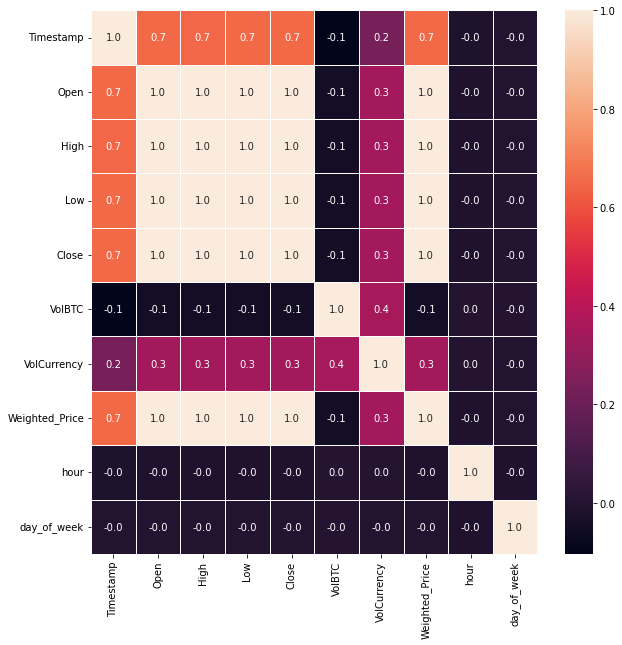

In [43]:
# Heatmap para visualizar correlação
corr = df_pandas.corr()
f,ax = plt.subplots(figsize = (10, 10))
sns.heatmap(corr, annot = True, linewidths = .5, fmt = '.1f', ax = ax)

Idealmente uma alta correlação entra as variáveis entrada e a variável de saída, e baixa correlação entre as variáveis de entrada!

<Figure size 864x360 with 0 Axes>

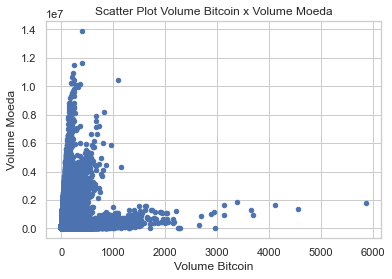

In [44]:
# Scatter Plot Volume Bitcoin x Volume Moeda
plt.figure(figsize = (12,5))
sns.set(style = 'whitegrid')
df_pandas.plot(kind = 'scatter', x = 'VolBTC', y = 'VolCurrency')
plt.xlabel('Volume Bitcoin')            
plt.ylabel('Volume Moeda')
plt.title('Scatter Plot Volume Bitcoin x Volume Moeda') 
plt.show()

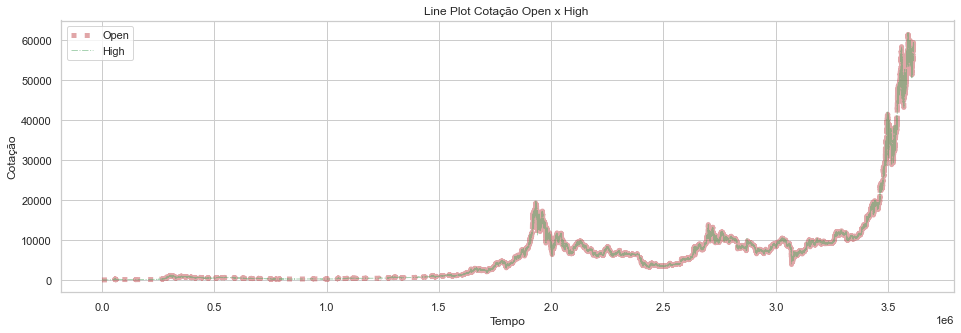

In [45]:
# Line Plot Cotação Open x High 
plt.figure(figsize = (16,5))
df_pandas.Open.plot(kind = 'line', 
                    color = 'r', 
                    label = 'Open', 
                    alpha = 0.5, 
                    linewidth = 5, 
                    grid = True, 
                    linestyle = ':')
df_pandas.High.plot(color = 'g', 
                    label = 'High', 
                    linewidth = 1, 
                    alpha = 0.5, 
                    grid = True, 
                    linestyle = '-.')
plt.legend(loc = 'upper left') 
plt.xlabel('Tempo')
plt.ylabel('Cotação')
plt.title('Line Plot Cotação Open x High ')
plt.show()

<AxesSubplot:ylabel='Frequency'>

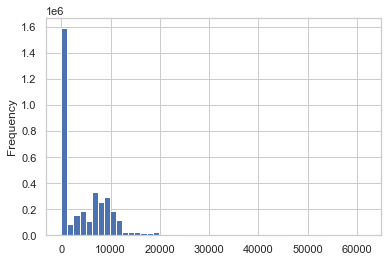

In [46]:
# Histograma da cotação de abertura
df_pandas.Open.plot(kind = 'hist', bins = 50)

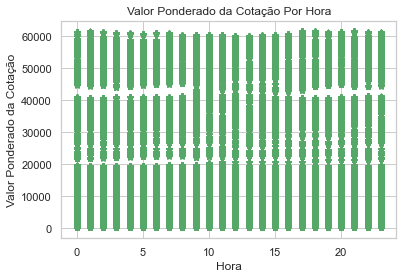

In [47]:
# Plot do valor ponderado da cotação (variável alvo) por hora
plt.plot(hour, weighted_price, 'g*')
plt.xlabel('Hora')            
plt.ylabel('Valor Ponderado da Cotação')
plt.title('Valor Ponderado da Cotação Por Hora') 
plt.show()

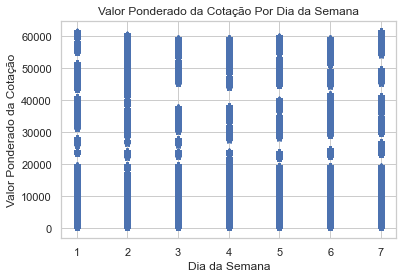

In [48]:
# Plot do valor ponderado da cotação por dia da semana
plt.plot(date_of_week, weighted_price, 'b*')
plt.xlabel('Dia da Semana')            
plt.ylabel('Valor Ponderado da Cotação')
plt.title('Valor Ponderado da Cotação Por Dia da Semana') 
plt.show()

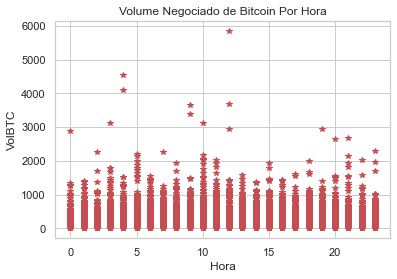

In [49]:
# Plot do VolBTC por hora
plt.plot(hour, volumeBTC, 'r*')
plt.xlabel('Hora')            
plt.ylabel('VolBTC')
plt.title('Volume Negociado de Bitcoin Por Hora') 
plt.show()

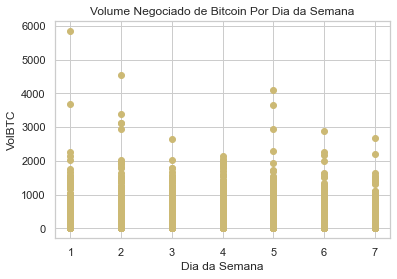

In [50]:
# Plot de VolBTC por dia da semana
plt.plot(date_of_week, volumeBTC, 'yo')
plt.xlabel('Dia da Semana')            
plt.ylabel('VolBTC')
plt.title('Volume Negociado de Bitcoin Por Dia da Semana') 
plt.show()

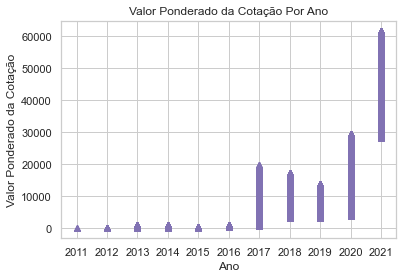

In [51]:
# Plot do valor ponderado da cotação por ano
plt.plot(year, weighted_price, 'm^')
plt.xlabel('Ano')            
plt.ylabel('Valor Ponderado da Cotação')
plt.title('Valor Ponderado da Cotação Por Ano') 
plt.show()

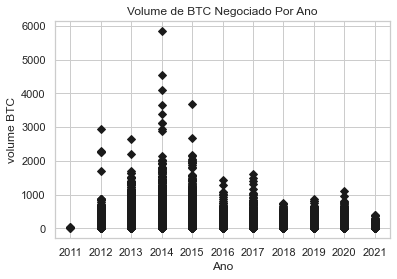

In [52]:
# Plot do Volume por ano
plt.plot(year, volumeBTC, 'kD')
plt.xlabel('Ano')            
plt.ylabel('volume BTC')
plt.title('Volume de BTC Negociado Por Ano') 
plt.show()

## Engenharia de Atributos com PySpark

In [53]:
df_bitcoin.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)



In [54]:
# Preparando o vetor de atributos
# Utilizando às variáveis Open, VolBTC e VolCurrency como variáveis preditoras
assembler = VectorAssembler(inputCols = ['Open', 'VolBTC', 'VolCurrency'],
                           outputCol = 'features')

In [55]:
# Cria o dataframe do vetor de atributos
df_assembled = assembler.transform(df_bitcoin)

In [56]:
# Visualizando os dados
df_assembled.show(10, truncate=False)

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+------------------------------+
|Timestamp |Open|High|Low |Close|VolBTC     |VolCurrency |Weighted_Price|dateTime           |features                      |
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+------------------------------+
|1325317920|4.39|4.39|4.39|4.39 |0.45558087 |2.0000000193|4.39          |2011-12-31 05:52:00|[4.39,0.45558087,2.0000000193]|
|1325346600|4.39|4.39|4.39|4.39 |48.0       |210.72      |4.39          |2011-12-31 13:50:00|[4.39,48.0,210.72]            |
|1325350740|4.5 |4.57|4.5 |4.57 |37.86229723|171.38033753|4.5264114983  |2011-12-31 14:59:00|[4.5,37.86229723,171.38033753]|
|1325350800|4.58|4.58|4.58|4.58 |9.0        |41.22       |4.58          |2011-12-31 15:00:00|[4.58,9.0,41.22]              |
|1325391360|4.58|4.58|4.58|4.58 |1.502      |6.87916     |4.58          |2012-01-01 02:16:00|[4.58,1.502,6.87916]          |


## Normalização

Os dados devem ser normalizados, pois a grande maioria dos algoritmos de ML, supõem que os dados estão na mesma escala, caso não estejam podem trazer previsões equivocadas.

In [57]:
# Dividindo os dados em treino e teste
dados_treino, dados_teste = df_assembled.randomSplit([.7, .3], seed = rnd_seed)

In [58]:
# Tipo do objeto
type(dados_treino)

pyspark.sql.dataframe.DataFrame

In [59]:
# Criando o scaler
scaler = MinMaxScaler(inputCol = 'features', outputCol = 'scaled_features')

In [60]:
# Fit nos dados de treino
scalerModel = scaler.fit(dados_treino)

**Toda e qualquer transformação aplicada em treino, deve ser aplicada em teste e novos dados.**

In [61]:
# Fit e transform nos dados de treino
dados_treino_scaled = scalerModel.transform(dados_treino)

In [62]:
# Transform no dados de teste
dados_teste_scaled = scalerModel.transform(dados_teste)

In [63]:
# Visualizando os daados
dados_treino_scaled.select('features', 'scaled_features').show(10, truncate = False)

+-------------------------------+-------------------------------------------------------------------+
|features                       |scaled_features                                                    |
+-------------------------------+-------------------------------------------------------------------+
|[4.39,48.0,210.72]             |[9.557729822093386E-6,0.008199728766573702,1.51589789206087E-5]    |
|[4.5,37.86229723,171.38033753] |[1.1339679449941311E-5,0.006467928495112392,1.2328924278777876E-5] |
|[4.58,9.0,41.22]               |[1.263564281564889E-5,0.001537449143732569,2.9653241795154263E-6]  |
|[4.84,10.0,48.4]               |[1.6847523754198516E-5,0.001708276826369521,3.4818459555688167E-6] |
|[5.0,10.1,50.5]                |[1.9439450485613674E-5,0.0017253595946332162,3.63291778421953E-6]  |
|[5.14,0.68,3.4952]             |[2.170738637560193E-5,1.1616282419312745E-4,2.5144107404760596E-7] |
|[5.26,29.31939163,154.21999997]|[2.36513314241633E-5,0.00500856372847815,1.109442

In [64]:
dados_treino_scaled.columns

['Timestamp',
 'Open',
 'High',
 'Low',
 'Close',
 'VolBTC',
 'VolCurrency',
 'Weighted_Price',
 'dateTime',
 'features',
 'scaled_features']

## Machine Learning

> Versão 1 do Modelo (Benchmark)

In [65]:
# Criando o modelo de regressão
modelo_lr_v1 = (LinearRegression(featuresCol = 'scaled_features',
                                labelCol = 'Weighted_Price',
                                predictionCol = 'Predicted_price',
                                maxIter = 100,
                                regParam = 0.3,
                                elasticNetParam = 0.8,
                                standardization = False))

In [66]:
# Treinando o modelo
modelo_v1 = modelo_lr_v1.fit(dados_treino_scaled)

Se tiver mensagem de WARN, isso indica que o Spark não encontrou a biblioteca de otimização de álgebra linear (que precisa ser instalada, mas não é requerida para este projeto). Mais detalhes aqui:

https://spark.apache.org/docs/latest/ml-linalg-guide.html

In [67]:
# Salvando o modelo
modelo_v1.write().overwrite().save('modelos/modelo_v1')

## Avaliação do Modelo

In [68]:
# Previsão com dados de teste
previsoes_v1 = modelo_v1.transform(dados_teste_scaled)

In [69]:
# Selecionando às colunas
pred_data_v1 = previsoes_v1.select("Predicted_price", "Weighted_Price").show(10)

+-----------------+--------------+
|  Predicted_price|Weighted_Price|
+-----------------+--------------+
|7.452060192894729|          4.39|
|7.641960478636686|          4.58|
|8.061740057645222|           5.0|
|8.381572117842202|          5.32|
|8.351587862198736|          5.29|
|8.351587862198736|          5.29|
| 8.25164034338718|          5.19|
|8.421551125366825|  5.3604618117|
|8.811346448731895|   5.777027027|
|9.061215245760785|           6.0|
+-----------------+--------------+
only showing top 10 rows



In [70]:
# Mean Absolute Error
print("Mean Absolute Erro (MAE) nos dados de teste: {}".format(modelo_v1.summary.meanAbsoluteError))
 

Mean Absolute Erro (MAE) nos dados de teste: 5.017385733181623


In [71]:
# Criando um avaliador para o modelo de regressão
evaluator = RegressionEvaluator(labelCol = 'Weighted_Price',
                               predictionCol = 'Predicted_price',
                               metricName = 'rmse')

In [72]:
# Aplicando o avaliador
rmse_v1 = evaluator.evaluate(previsoes_v1)
print('Root Man Squared Error (RMSE) nos dados de teste = %g' % rmse_v1)

Root Man Squared Error (RMSE) nos dados de teste = 11.2879


In [73]:
# Extraindo às previsões
pred_results_v1 = modelo_v1.evaluate(dados_teste_scaled)

In [74]:
# Valores reais de Y sendo convertidos para o formato do Pandas
Y = pred_results_v1.predictions.select('Weighted_Price').toPandas()

In [75]:
# Valores reais de Y sendo convertidos para o formato do Pandas
_Y = pred_results_v1.predictions.select('Predicted_price').toPandas()

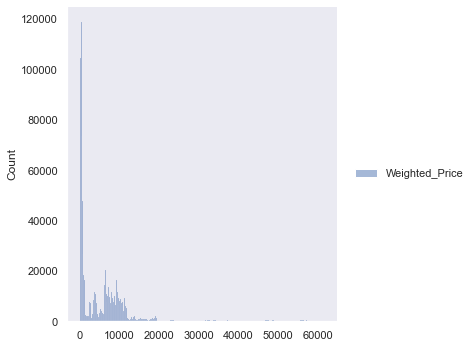

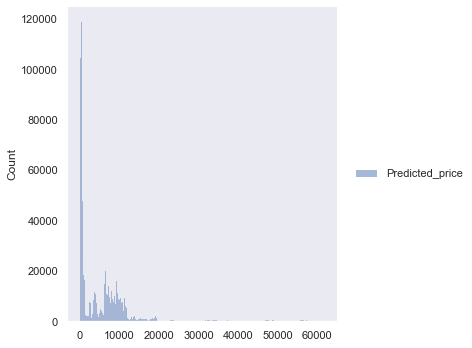

In [76]:
# Distribuição dos valores reais x valores previstos
sns.set_style("dark")
ax1 = sns.displot(Y, color = "r", label = "Valores Reais")
sns.displot(_Y, color = "b", label = "Valores Previstos")

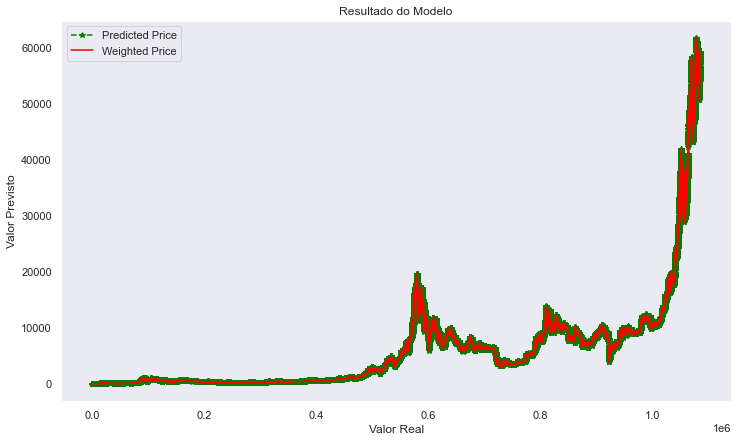

In [77]:
# Plot dos valores reais x valores previstos
plt.figure(figsize = (12,7))
plt.plot(Y, color = 'green', marker = '*', linestyle = 'dashed', label = 'Predicted Price')
plt.plot(_Y, color = 'red', label = 'Weighted Price')
plt.title('Resultado do Modelo')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.legend()

> Versão 2 do Modelo (Otimização de Hiperparâmetros)

In [78]:
# Criando o modelo
modelo_lr_v2 = (LinearRegression(featuresCol = 'scaled_features',
                                labelCol = 'Weighted_Price',
                                predictionCol = 'Predicted_price'))

In [79]:
# Criando um grid para otimização de hiperparâmetros
grid = ParamGridBuilder().addGrid(modelo_lr_v2.maxIter, [50, 100]).build()

In [80]:
# Criando o avaliador (utilizado na validação cruzada)
evaluator = RegressionEvaluator(labelCol = 'Weighted_Price',
                               predictionCol = 'Predicted_price',
                               metricName = 'rmse')

In [81]:
# Criando o CrossValidator
cv = CrossValidator(estimator = modelo_lr_v2, estimatorParamMaps = grid, evaluator = evaluator, parallelism = 2)

In [82]:
%%time

# Treinando o CrossValidator
cvModel = cv.fit(dados_treino_scaled)

CPU times: total: 703 ms
Wall time: 2min 36s


In [83]:
# Extraindo o melhor modelo do CrossValidator
modelo_v2 = cvModel.bestModel

In [84]:
# Salvando o modelo em disco
modelo_v2.write().overwrite().save('modelos/modelo_v2')

## Avaliação do Modelo

In [85]:
# Previsões com dados de teste
previsoes_v2 = modelo_v2.transform(dados_teste_scaled)

In [86]:
# Seleciona as colunas
pred_data_v2 = previsoes_v2.select("Predicted_price", "Weighted_Price").show(10)

+------------------+--------------+
|   Predicted_price|Weighted_Price|
+------------------+--------------+
| 4.508108472357593|          4.39|
| 4.697545264575934|          4.58|
| 5.108091101746675|           5.0|
| 5.437041429505176|          5.32|
| 5.392532805262221|          5.29|
| 5.402256707831288|          5.29|
|5.3069234754546475|          5.19|
| 5.470987379974378|  5.3604618117|
| 5.860328227652778|   5.777027027|
| 6.117129927737251|           6.0|
+------------------+--------------+
only showing top 10 rows



In [87]:
# Mean Absolute Error
print("MAE: {0}".format(modelo_v2.summary.meanAbsoluteError))

MAE: 3.388028733539672


In [88]:
evaluator = RegressionEvaluator(labelCol = "Weighted_Price", 
                                predictionCol = "Predicted_price", 
                                metricName = "rmse")

In [89]:
# Aplica o avaliador
rmse_v2 = evaluator.evaluate(previsoes_v2)
print("Root Mean Squared Error (RMSE) nos dados de teste = %g" % rmse_v2)

Root Mean Squared Error (RMSE) nos dados de teste = 10.3524


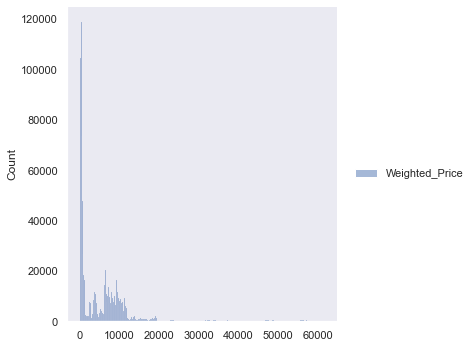

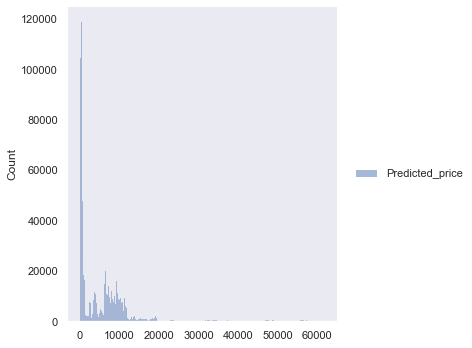

In [90]:
# Plot dos valores reais x valores previstos

# Extrai as previsões
pred_results_v2 = modelo_v2.evaluate(dados_teste_scaled)

# Valores reais de Y sendo convertidos para o formato do Pandas
Y = pred_results_v2.predictions.select('Weighted_Price').toPandas()

# Valores previstos de Y sendo convertidos para o formato do Pandas
_Y = pred_results_v2.predictions.select("Predicted_price").toPandas()

# Plot
sns.set_style("dark")
ax1 = sns.displot(Y, color = "r", label = "Valores Reais")
sns.displot(_Y, color = "b", label = "Valores Previstos")

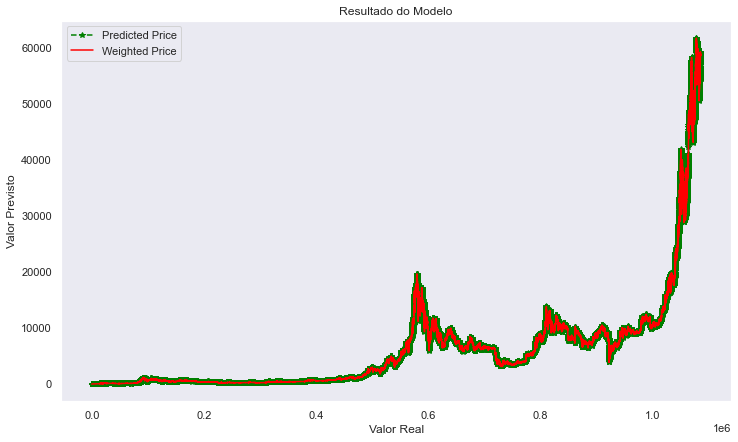

In [91]:
# Plot dos valores reais x valores previstos
plt.figure(figsize = (12,7))
plt.plot(Y, color = 'green', marker = '*', linestyle = 'dashed', label = 'Predicted Price')
plt.plot(_Y, color = 'red', label = 'Weighted Price')
plt.title('Resultado do Modelo')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.legend()

As mensagens de WARN no treinamento do modelo_v2 indicam que o modelo parece instável e talvez esteja com overfitting. Usaremos o modelo_v1.

## Previsões em Tempo Real

In [92]:
# Novos dados
novos_dados = [[20546.29, 3422.57, 72403082.02], [21620.85, 3271.14, 71319207.5]]

In [93]:
# Prepara o dataframe do Pandas
df_novos_dados = pd.DataFrame(novos_dados, columns = ['Open', 'VolBTC', 'VolCurrency'])

In [94]:
# Visualiza
df_novos_dados

,Open,VolBTC,VolCurrency
0,20546.29,3422.57,72403082.02
1,21620.85,3271.14,71319207.50


In [95]:
# Converte o dataframe do Pandas para dataframe do Spark
df_novos_dados_spark = spark_session.createDataFrame(df_novos_dados) 

In [96]:
# Visualiza
df_novos_dados_spark.show()

+--------+-------+-------------+
|    Open| VolBTC|  VolCurrency|
+--------+-------+-------------+
|20546.29|3422.57|7.240308202E7|
|21620.85|3271.14| 7.13192075E7|
+--------+-------+-------------+



In [97]:
# Cria o dataframe do vetor de atributos
df_assembled = assembler.transform(df_novos_dados_spark)

In [98]:
# Visualiza os dados
df_assembled.show()

+--------+-------+-------------+--------------------+
|    Open| VolBTC|  VolCurrency|            features|
+--------+-------+-------------+--------------------+
|20546.29|3422.57|7.240308202E7|[20546.29,3422.57...|
|21620.85|3271.14| 7.13192075E7|[21620.85,3271.14...|
+--------+-------+-------------+--------------------+



In [99]:
# Normaliza os dados
df_assembled_scaled = scalerModel.transform(df_assembled)

In [100]:
# Previsões com os novos dados
previsoes = modelo_v1.transform(df_assembled_scaled)

In [101]:
# Imprime as previsões
pred_data = previsoes.select("Predicted_price").show()

+------------------+
|   Predicted_price|
+------------------+
| 20538.57142694398|
|21612.567485085438|
+------------------+



In [102]:
# Encerrando a sessão Spark
spark_session.stop()

# Conclusão

Apesar do modelo_v2 parecer ser melhor otimizado, ao treinar o modelo, recebemos diversos avisos de Warning, e como a taxa MAE e RMSE são parecidas, portanto o modelo_v1 foi utilizado por possuir otimização de hiperparâmetros melhor e ser mais estável.